We build intuition for how peptidergic connectivity could partition cells into meaningful groups even in the absence of explicit gene expression information with a toy problem.

The type x type adjacency matrix can be sampled to obtain a cell x cell adjacency matrix. The block structure is equivalent to the graph having distinct connected components.

We generate embeddings of these graphs with Spectral graph clustering and Node2Vec to identify such components.

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from cci.sim import Interactions
from rich import print as rprint
from torch_geometric.utils import from_scipy_sparse_matrix
import torch
from torch_geometric.nn import Node2Vec
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"



In [112]:
from sklearn.manifold import TSNE

def showplot(embedding, color):
    embedding_ = embedding.numpy()

    z = TSNE(n_components=2).fit_transform(embedding_)

    plt.figure(figsize=(3, 3))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=5, c= color, cmap = "Paired")
    plt.show()
    return


for the 0 communication channel:


{0: ['b', 'c', 'f', 'h'], 1: ['a', 'd', 'e', 'g']}

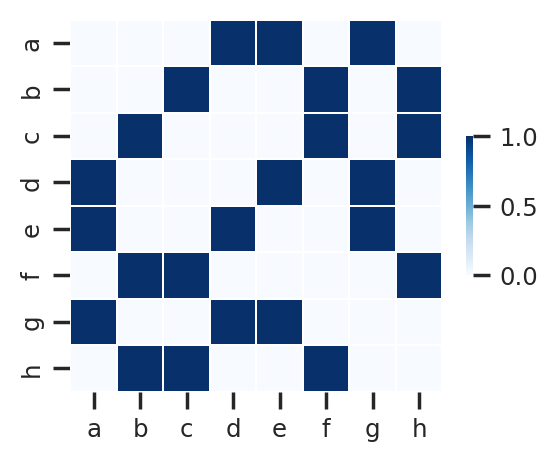

for the 1 communication channel:


{0: ['b', 'c', 'f', 'h'], 1: ['a', 'd', 'e', 'g']}

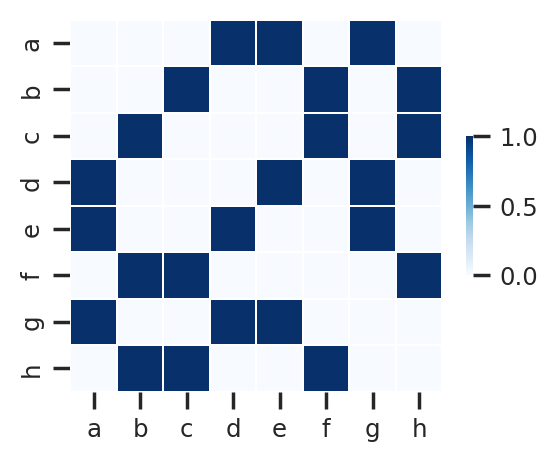

for the 2 communication channel:


{0: ['b', 'd', 'f', 'h'], 1: ['a', 'c', 'e', 'g']}

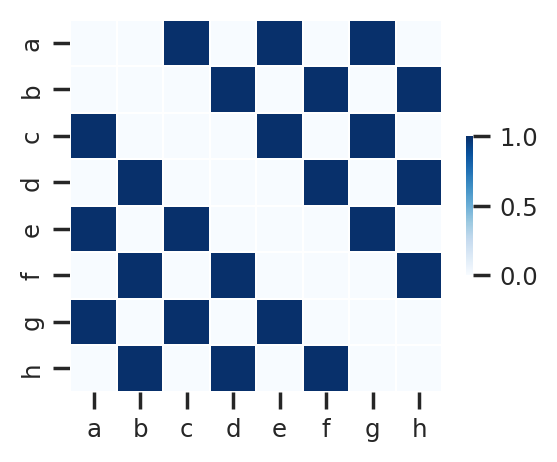

In [8]:
# Used to create simulation data
C = Interactions(n_blocks_per_graph=2, seed=0)

# Get label x label adjacency matrices
b_ch, A_ch = C.get_adj_per_channel()
for ch in range(C.n_channels):
    print(f"for the {ch} communication channel:")
    rprint(b_ch[ch])
    f, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.heatmap(A_ch[ch],ax=ax, cmap="Blues", cbar_kws={'shrink':0.3}, square=True, linewidths=0.1)
    plt.show()


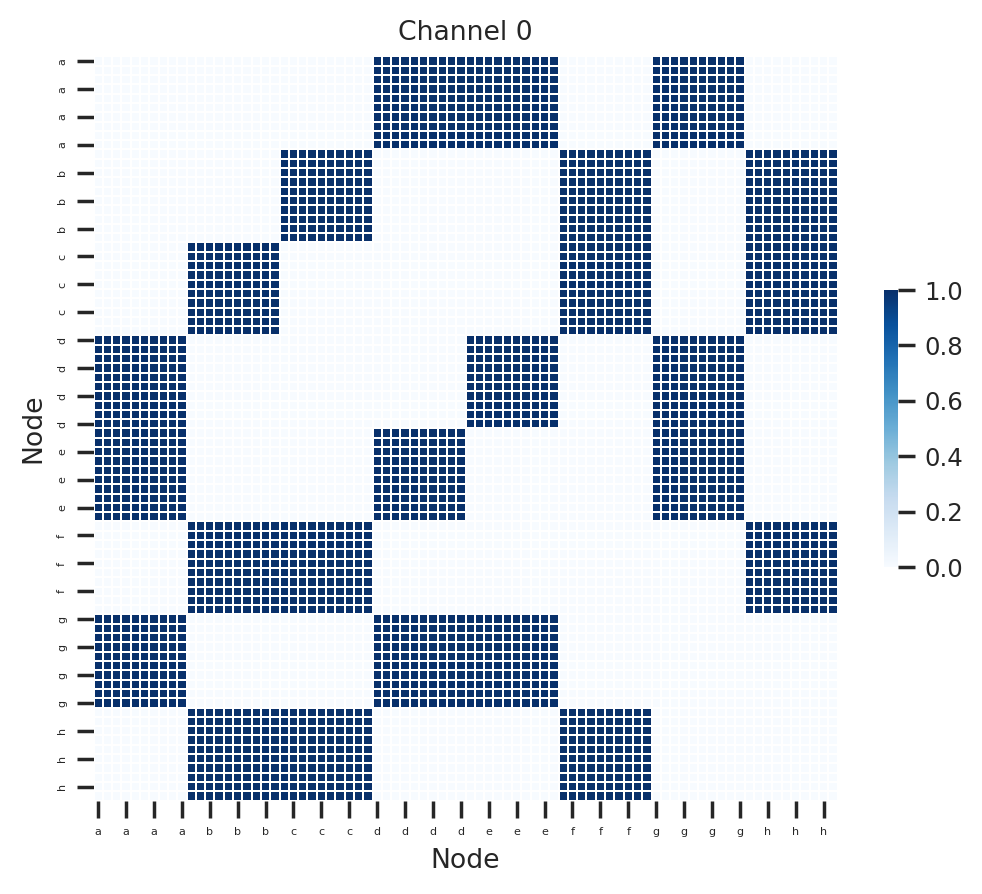

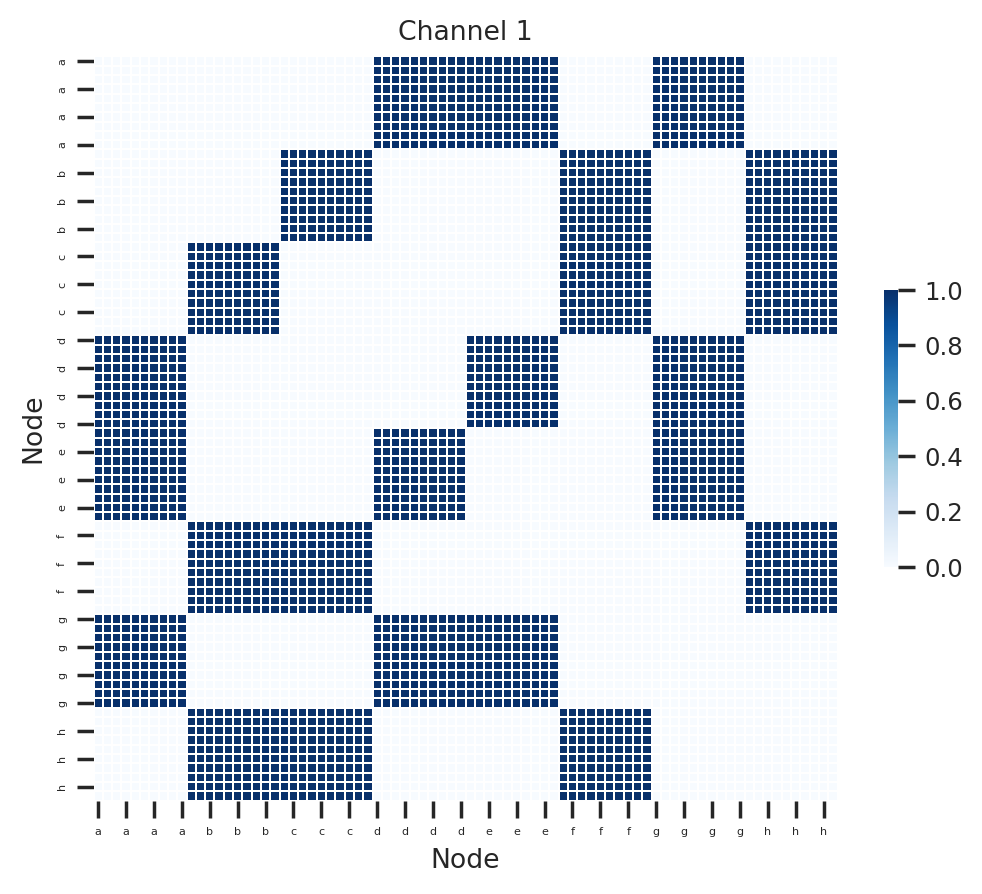

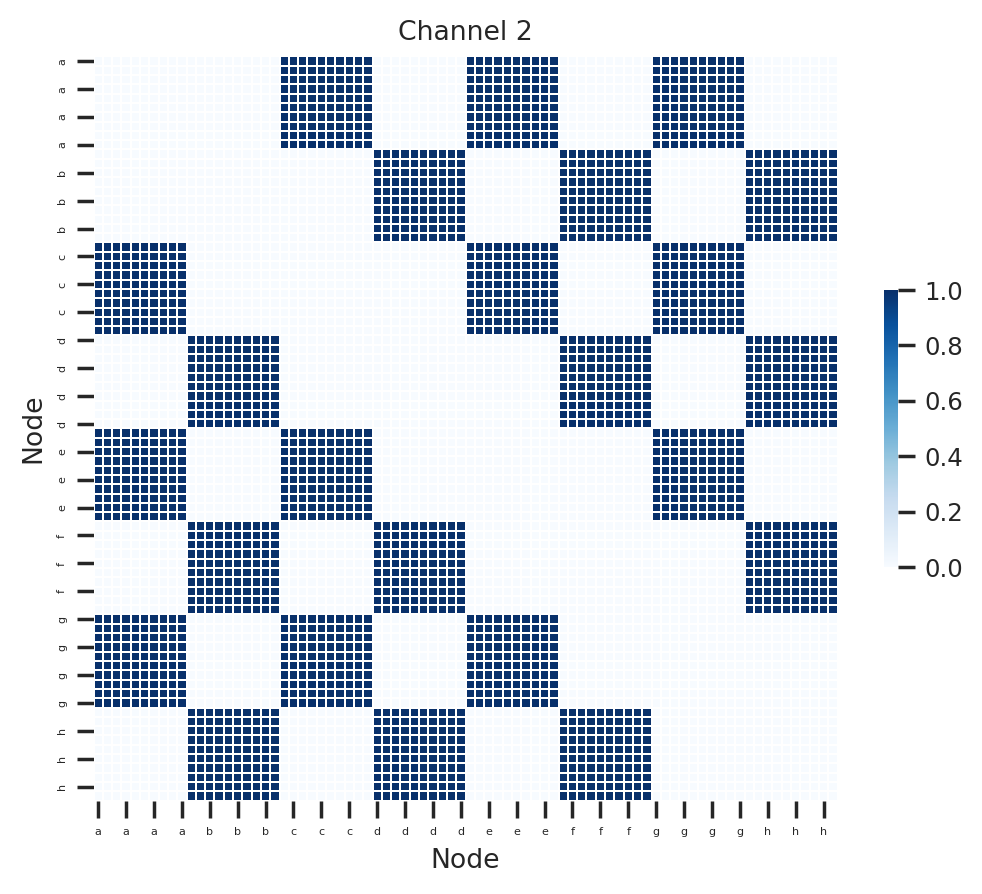

In [60]:
# Get node x node graphs from all channels

A_list = []
block_labels_list = []
for i in range(C.n_channels):
    node_labels, A = C.get_sample_adj(A_ch[i])
    A_list.append(A)
    block_labels_list.append(C.get_block_labels(b_ch[i]))
    A = pd.DataFrame(A, index=node_labels, columns=node_labels)

    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(A,ax=ax, cmap="Blues", cbar_kws={'shrink':0.3}, square=True, linewidths=0.1)
    ax.set(xlabel="Node", ylabel="Node")
    # make ticks small
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.title("Channel " + str(i))
    plt.show()

Spectral clustering frames the problem as an eigen decomposition. Specifically, the eigenvectors of the Laplacian matrix are used as features for clustering.


In [74]:
# Use spectral graph clustering to identify distinct connected components
from sklearn.cluster import SpectralClustering
from sklearn import metrics

sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(A_list[0])
adjusted_rand_score = np.round(metrics.adjusted_rand_score(block_labels_list[0], sc.labels_), 2)
mutal_info_score = np.round(metrics.adjusted_mutual_info_score(block_labels_list[0], sc.labels_), 2)
print("Adjusted rand score: ", adjusted_rand_score)
print("Mutual information score: ", mutal_info_score)

Adjusted rand score:  1.0
Mutual information score:  1.0


/allen/programs/celltypes/workgroups/mousecelltypes/Donghyun/envs/miniconda3/envs/pyg/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [85]:
# Use Node2Vec to identify distinct connected components

# Get edge index from node x node adjacency matrix
adj = torch.tensor(A_list[0], dtype=torch.long)
edge_index = adj.nonzero().t().contiguous()

In [101]:
# Node2vec parameters
p=1.0
q=1.0
embedding_dim=16
walk_length=10
context_size=10
walks_per_node=1
num_nodes=len(C.get_node_labels())
batch_size=128
num_negative_samples=1


In [105]:
# Node2vec model, optimizer, and loader
model = Node2Vec(edge_index, embedding_dim=embedding_dim, walk_length=walk_length,
        context_size=context_size, walks_per_node=walks_per_node,
        num_negative_samples=num_negative_samples, p=p, q=q, sparse=True)

optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
loader = model.loader(batch_size=batch_size, shuffle=True)


In [115]:
# Train the model 
model.train()
epochs = 500

for epoch in range(epochs):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss = total_loss / len(loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}', flush=True) 

Epoch: 00, Loss: 1.1493
Epoch: 01, Loss: 1.1276
Epoch: 02, Loss: 1.1039
Epoch: 03, Loss: 1.1391
Epoch: 04, Loss: 1.1393
Epoch: 05, Loss: 1.1569
Epoch: 06, Loss: 1.1506
Epoch: 07, Loss: 1.1491
Epoch: 08, Loss: 1.1218
Epoch: 09, Loss: 1.1363
Epoch: 10, Loss: 1.1441
Epoch: 11, Loss: 1.0830
Epoch: 12, Loss: 1.1278
Epoch: 13, Loss: 1.1579
Epoch: 14, Loss: 1.1131
Epoch: 15, Loss: 1.1610
Epoch: 16, Loss: 1.1536
Epoch: 17, Loss: 1.0915
Epoch: 18, Loss: 1.1619
Epoch: 19, Loss: 1.1465
Epoch: 20, Loss: 1.1441
Epoch: 21, Loss: 1.1516
Epoch: 22, Loss: 1.1221
Epoch: 23, Loss: 1.1354
Epoch: 24, Loss: 1.1122
Epoch: 25, Loss: 1.1249
Epoch: 26, Loss: 1.1499
Epoch: 27, Loss: 1.1335
Epoch: 28, Loss: 1.1401
Epoch: 29, Loss: 1.1652
Epoch: 30, Loss: 1.1498
Epoch: 31, Loss: 1.1278
Epoch: 32, Loss: 1.1085
Epoch: 33, Loss: 1.1403
Epoch: 34, Loss: 1.0934
Epoch: 35, Loss: 1.1401
Epoch: 36, Loss: 1.1329
Epoch: 37, Loss: 1.1344
Epoch: 38, Loss: 1.1453
Epoch: 39, Loss: 1.1414
Epoch: 40, Loss: 1.1317
Epoch: 41, Loss:

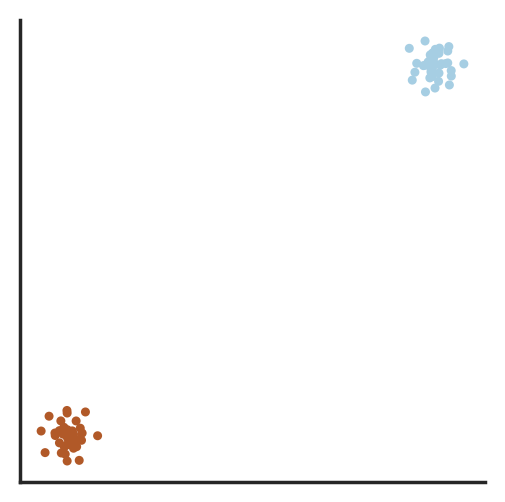

In [116]:
# Plot embeddings (color corresponds to assigned connected component)

showplot(embedding=model().detach(), color=block_labels_list[0])